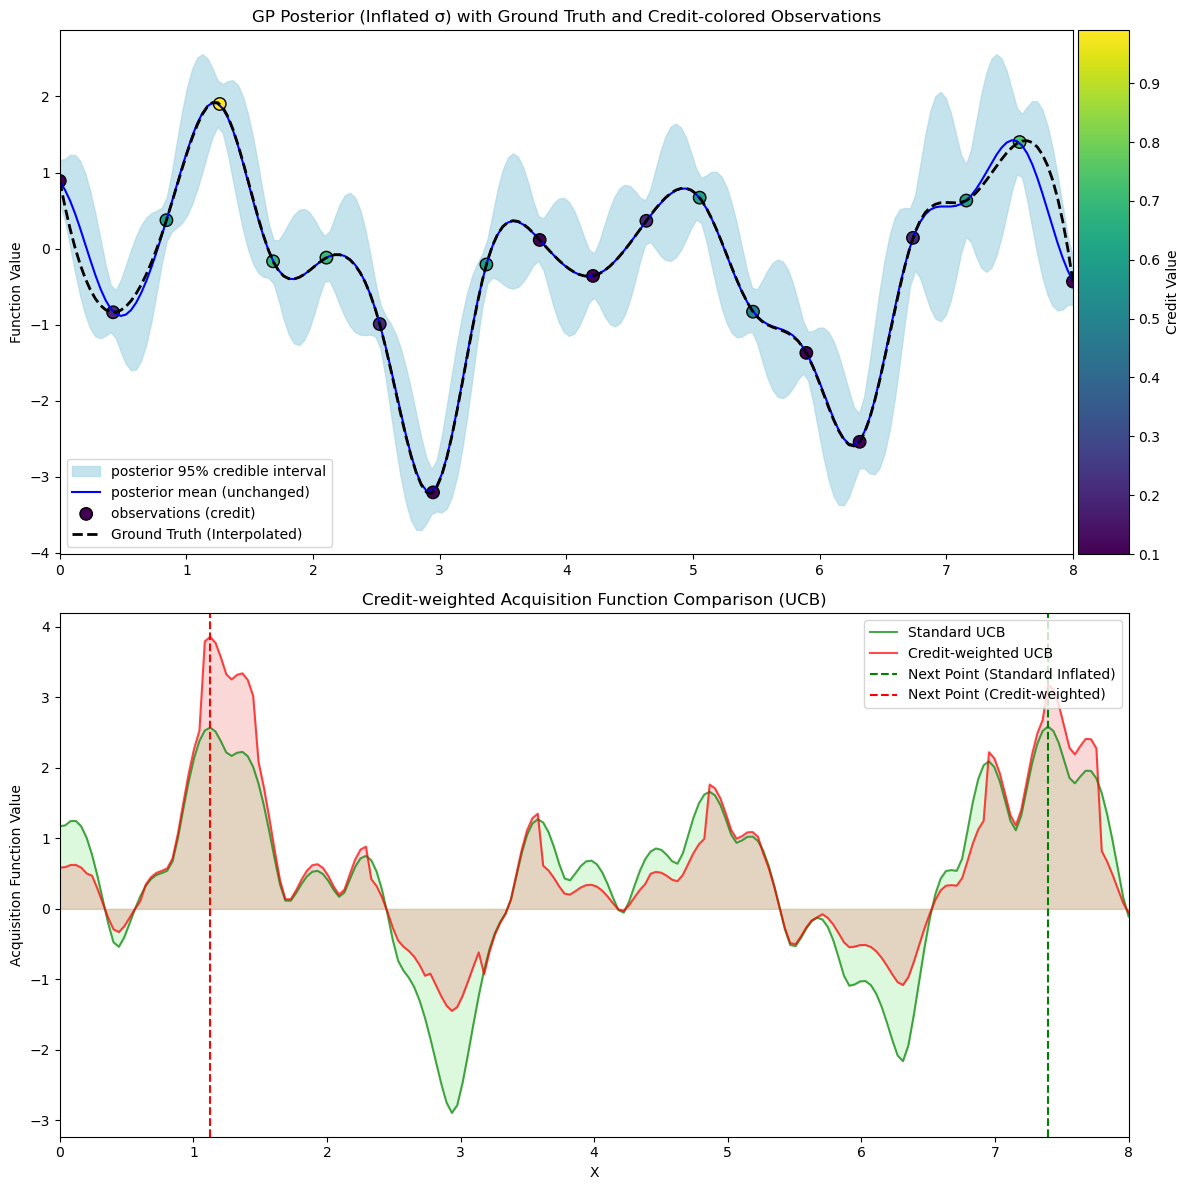

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
from scipy.stats import norm
from scipy.spatial.distance import cdist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d  # 用于插值

# ============== 1. 生成或修改数据 ==============
np.random.seed(7)
X_obs = np.linspace(0, 8, 20).reshape(-1, 1)
Y_obs = np.sin(2 * (X_obs + 2.5)) + 0.5 * np.cos(0.5 * (X_obs + 2.5)) + 1 * np.random.randn(20, 1)
Y_obs[3] += 0.7
data_points = np.hstack((X_obs, Y_obs))

# ============== 2. 拟合 GP，缩小核函数 lengthscale ==============
kernel = GPy.kern.RBF(input_dim=1, lengthscale=0.5)  
gp_model = GPy.models.GPRegression(X_obs, Y_obs, kernel=kernel)
gp_model.Gaussian_noise.variance = 0.01
gp_model.optimize()

# 在 [0,8] 上做预测
X = np.linspace(0, 8, 200).reshape(-1, 1)
mu, variance = gp_model.predict(X)
sigma = np.sqrt(variance)

# 从 GP 后验中采样几条曲线，用于可视化
samples = gp_model.posterior_samples_f(X, size=0)

# 拟合“Ground Truth”插值曲线（只为可视化）
f_ground = interp1d(X_obs.flatten(), Y_obs.flatten(), kind='cubic', fill_value="extrapolate")
Y_ground = f_ground(X.flatten())

# ============== 3. 定义并计算 UCB 采集函数 (基于原始 GP 预测) ==============
def UCB(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

ucb = UCB(mu.flatten(), sigma.flatten(), kappa=2.0)
next_x = X[np.argmax(ucb)]  # 标准 UCB 选点

# ============== 4. 人为放大标准差 (不修改均值) ==============
boost_center = 7.0      # 目标 X 值附近
boost_width = 0.5       # 影响范围（标准差）
sigma_boost = 1.7       # sigma 的放大倍数

# 计算一个高斯形状的权重，决定在 x=7 附近放大多少
boost_weight = np.exp(-((X.flatten() - boost_center)**2) / (2 * boost_width**2))

# 仅放大标准差，不改均值
mod_mu = mu.flatten().copy()
mod_sigma = sigma.flatten().copy() * (1 + (sigma_boost - 1) * boost_weight)

# ============== 5. 利用原始模型对观测点计算 credit ==============
mu_hist, sigma_hist = gp_model.predict(X_obs)
mu_hist = mu_hist.flatten()
sigma_hist = sigma_hist.flatten()

Z_val = Y_obs.max()  
eps = 1e-6
raw_credits = norm.pdf(Z_val, loc=mu_hist, scale=sigma_hist + eps)
# credits = (raw_credits - np.min(raw_credits)) / (np.max(raw_credits) - np.min(raw_credits) + eps)


credits =  np.array([0.1,0.2,0.6,0.99,0.7,
            0.7,0.2,0.1,0.6,0.1,
            0.1,0.2,0.6,0.5,0.1,
            0.1,0.2,0.6,0.75,0.1,])

# ============== 6. 可视化：GP后验 & Credit ==============
fig = plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2, sharex=ax1)

# 在上图中使用“只放大标准差后的”GP预测
ax1.fill_between(X.flatten(), (mod_mu - 1.96 * mod_sigma),
                             (mod_mu + 1.96 * mod_sigma),
                 color='lightblue', alpha=0.7, label='posterior 95% credible interval')
ax1.plot(X, mod_mu, 'b-', label='posterior mean (unchanged)')
for i in range(samples.shape[2]):
    ax1.plot(X, samples[:, :, i], 'r-', alpha=0.6)

# 观测点（用信用值上色）
sc = ax1.scatter(X_obs, Y_obs, c=credits, cmap='viridis', s=80, edgecolor='k',
                 label='observations (credit)')
ax1.plot(X, Y_ground, 'k--', linewidth=2, label='Ground Truth (Interpolated)')
ax1.legend(loc='lower left')
ax1.set_ylabel('Function Value')
ax1.set_title('GP Posterior (Inflated σ) with Ground Truth and Credit-colored Observations')

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(sc, cax=cax, label='Credit Value')

# ============== 7. 计算并对比 Standard UCB 与 Credit-weighted UCB ==============
# 这里的 “standard UCB” 也用修改后的 σ
ucb_standard = UCB(mod_mu, mod_sigma, kappa=2.0)

# 为每个测试点分配 credit（取最近观测点的 credit）
dists = cdist(X, X_obs)
nearest_indices = np.argmin(dists, axis=1)
candidate_credits = credits[nearest_indices]
normalized_candidate_credits = (candidate_credits - candidate_credits.min()) / (candidate_credits.max() - candidate_credits.min() + 1e-9)
ucb_credit = ucb_standard * (normalized_candidate_credits + 0.5)

next_x_standard = X[np.argmax(ucb_standard)]
next_x_credit = X[np.argmax(ucb_credit)]

ax2.plot(X, ucb_standard, 'g-', label='Standard UCB', alpha=0.7)
ax2.plot(X, ucb_credit, 'r-', label='Credit-weighted UCB', alpha=0.7)
ax2.fill_between(X.flatten(), 0, ucb_standard, color='lightgreen', alpha=0.3)
ax2.fill_between(X.flatten(), 0, ucb_credit, color='lightcoral', alpha=0.3)
ax2.axvline(next_x_standard, color='g', linestyle='--', label='Next Point (Standard Inflated)')
ax2.axvline(next_x_credit, color='r', linestyle='--', label='Next Point (Credit-weighted)')
ax2.legend(loc='upper right')
ax2.set_xlabel('X')
ax2.set_ylabel('Acquisition Function Value')
ax2.set_title('Credit-weighted Acquisition Function Comparison (UCB)')

for ax in [ax1, ax2]:
    ax.set_xlim(0, 8)

plt.tight_layout()
plt.show()
